In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models import *
plt.style.use('ggplot')

In [2]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

In [3]:
fake_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [4]:
fake_df['truth'] = 0
true_df['truth'] = 1
all_news_df = pd.concat([fake_df, true_df])

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import plot_roc_curve, confusion_matrix, classification_report

In [6]:
def get_X_y_splits(df, X_col, y_col='truth'):
    ''' Takes a dataframe and returns a train test split for labeled data.
    Input: DataFrame, X column name (string), target column name (string).
    Ouput: X_train, X_test, y_train, y_test'''
    X = df[X_col].values
    y = df[y_col].values
    return train_test_split(X, y)

In [7]:
X_train, X_test, y_train, y_test = get_X_y_splits(all_news_df, 'text')

In [8]:
nb_clf = naive_bayes_model(X_train,y_train)

In [22]:
nb_predicted = nb_clf.predict(X_test)
nb_clf.score(X_test, y_test)

0.9716703786191537

In [9]:
sgd_clf = stochastic_gradient_descent_model(X_train,y_train)

In [10]:
sgd_predicted = sgd_clf.predict(X_test)
sgd_clf.score(X_test, y_test)

0.9968819599109131

In [11]:
pa_clf = passive_aggressive_model(X_train,y_train)

In [12]:

pa_clf_predicted = pa_clf.predict(X_test)
pa_clf.score(X_test, y_test)

0.9942984409799555

In [15]:
coefs = np.array(pa_clf['clf'].coef_)
bag = pa_clf['vect'].get_feature_names()

AttributeError: 'GridSearchCV' object has no attribute 'clf'

In [43]:
top_n = np.argsort(coefs[0])[-15:][::-1]
for idx in top_n:
    print(bag[idx])

reuters
washington reuters
reuters the
said
said on
president donald
edt
republican
country
it is
reuters president
on tuesday
washington
on wednesday
on friday


(0.0, 0.2)

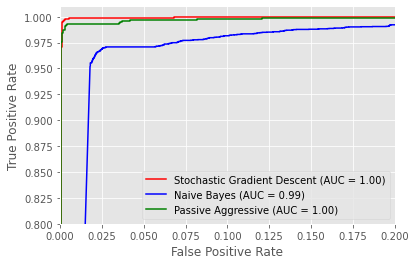

In [18]:
fig, ax = plt.subplots()
plot_roc_curve(sgd_clf, X_test, y_test, name='Stochastic Gradient Descent', ax=ax, color='red')
plot_roc_curve(nb_clf, X_test, y_test, name='Naive Bayes', ax=ax, color='blue')
plot_roc_curve(pa_clf, X_test, y_test, name='Passive Aggressive', ax=ax, color='green')
# plot_roc_curve(rfc_clf, X_test, y_test, name='Random Forest', ax=ax, color='purple')
ax.set_ylim(.8,1.01)
ax.set_xlim(0,.2)

In [19]:
confusion_matrix(y_test, sgd_predicted)

array([[5820,   24],
       [  11, 5370]])

In [23]:
confusion_matrix(y_test, nb_predicted)

array([[5683,  161],
       [ 157, 5224]])

In [21]:
confusion_matrix(y_test, pa_clf_predicted)

array([[5821,   23],
       [  41, 5340]])

In [17]:
print(classification_report(y_test, svm_predicted, target_names=['Fake News','Real News']))

              precision    recall  f1-score   support

   Fake News       1.00      0.99      0.99      5814
   Real News       0.99      1.00      0.99      5411

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

